
# **Valor Agregado a Nivel de Programa — Nariño 2019→2023**  
## **Caso: Ingeniería de Sistemas — Universidad Mariana**

Este cuaderno estima el **Valor Agregado (VA)** del **programa** de **Ingeniería de Sistemas** de la **Universidad Mariana** (Nariño, Colombia) para la cohorte **Saber 11 (2019)** → **Saber Pro (2023)**, usando baseline de **promedios municipales** de S11 (2019) y un **modelo OLS a nivel de programa**.

Incluye:
- Formulación matemática.
- Limpieza robusta (mojibake/acentos) y llave municipal (`key_muni`) con **forzado de PASTO** para la U. Mariana.
- Construcción de tabla **programa** (Institución × Programa) con `punt_global_prom`.
- **Merge** estable con baseline S11.
- **Validación** (CV k-fold), **tabla de coeficientes**, métricas.
- **VA del programa** objetivo con **IC95 (bootstrap)**.
- **Ranking** de VA en Nariño y **gráficas**.


## 1. Marco formal

Sea $p$ un **programa** (Institución × Programa), $m$ su municipio, $j$ áreas de Saber 11 y $k$ controles categóricos.

---

### Baseline municipal

$$
X^{S11}_{m,j}
$$

es el **promedio municipal de Saber 11 (2016)** en el área $j$.

---

### Llave municipal normalizada

Definimos la llave:

$$
\text{key\_muni} = g(\text{municipio}) = \mathrm{UPPER}(\mathrm{DEACCENT}(\mathrm{STRIP}(\mathrm{FIXENC}(\text{municipio}))))
$$

Con el ajuste institucional: si la institución es **Universidad Mariana**, entonces

$$
\text{key\_muni} = \text{PASTO}.
$$

---

### Target a nivel de programa

$$
Y^{SPro}_{p}
$$

es el **promedio del puntaje global de Saber Pro (2020)** del programa $p$.

---

### Modelo OLS

$$
Y^{SPro}_{p}
=
\beta_0
+
\sum_j \beta_j\, X^{S11}_{m,j}
+
\sum_k \gamma_k\, Z_{p,k}
+
\varepsilon_p
$$

donde $X^{S11}_{m,j}$ son los **baselines municipales** y $Z_{p,k}$ los **controles categóricos** del programa (p.ej., origen y carácter académico).

---

### Valor Agregado (VA) del programa

Predicción esperada para el programa $p$:

$$
\widehat{Y}^{SPro}_{p}
$$

y el **Valor Agregado**:

$$
VA_p = Y^{SPro}_{p} - \widehat{Y}^{SPro}_{p}.
$$

---

### Intervalo de confianza (bootstrap) del VA medio

Si existen múltiples observaciones del mismo programa, el IC95% del promedio $\overline{VA}_p$ se estima por bootstrap:

$$
CI_{95\%}(\overline{VA}_p) =
\big[\,Q_{2.5}(\overline{VA}^{*(b)}_p),\; Q_{97.5}(\overline{VA}^{*(b)}_p)\,\big].
$$



## 2. Rutas y carga de datos (ajusta a tu PC)


In [5]:

from pathlib import Path
import pandas as pd

# Ajusta estas rutas
PATH_S11  = Path(r'C:\Users\sebas\OneDrive\Documents\Maestria\Master\Icfes\2019\s11_2019_muni_summary.csv')
PATH_SPRO = Path(r'C:\Users\sebas\OneDrive\Documents\Maestria\Master\SaberPro\2023\spro_narino_2023.csv')

OUT_DIR = Path(r'C:\Temp\va_programa_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

print('S11  ->', PATH_S11)
print('SPro ->', PATH_SPRO)
print('OUT  ->', OUT_DIR)

s11 = pd.read_csv(PATH_S11)
sp  = pd.read_csv(PATH_SPRO, low_memory=False)
print('S11 shape:', s11.shape)
print('SPro shape:', sp.shape)


S11  -> C:\Users\sebas\OneDrive\Documents\Maestria\Master\Icfes\2019\s11_2019_muni_summary.csv
SPro -> C:\Users\sebas\OneDrive\Documents\Maestria\Master\SaberPro\2023\spro_narino_2023.csv
OUT  -> C:\Temp\va_programa_outputs
S11 shape: (18121, 19)
SPro shape: (4513, 25)



## 3. Normalización robusta (mojibake/acentos) y llave municipal


In [6]:

import re, unicodedata
import numpy as np

def fix_mojibake(s):
    if pd.isna(s): return s
    s = str(s)
    try: return s.encode('latin1').decode('utf-8')
    except Exception: return s

def norm_text(s):
    if pd.isna(s): return s
    s = str(s).upper().strip()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = re.sub(r'\s*\(.*?\)\s*', ' ', s)
    s = s.replace('.', ' ')
    s = ' '.join(s.replace('-', ' ').replace(',', ' ').split())
    return s

def unify_pasto(x):
    if pd.isna(x): return x
    x = norm_text(x)
    return 'PASTO' if x in {'SAN JUAN DE PASTO','PASTO','PASTO NARINO','PASTO NARIÑO','SANJUAN DE PASTO'} else x

def find_col(cands, df):
    for c in cands:
        if c in df.columns: return c
    return None

# S11 baseline
s11.columns = [c.strip() for c in s11.columns]
col_muni_s11 = find_col(['cole_mcpio_ubicacion','cole_mpio_ubicacion','cole_mcpio_ubicación','municipio','mcpio'], s11)
assert col_muni_s11, "No encontré columna municipal en S11"

if not any(c.startswith('s11_punt_') for c in s11.columns):
    s11 = s11.rename(columns={c: f's11_{c}' for c in s11.columns if c.startswith('punt_')})
base_cols = [c for c in s11.columns if c.startswith('s11_punt_')]
assert base_cols, "S11 no tiene columnas s11_punt_*"

s11['key_muni'] = s11[col_muni_s11].map(fix_mojibake).map(norm_text).map(unify_pasto)
s11_base = s11[['key_muni'] + base_cols].drop_duplicates()

# SPro 2020
sp.columns = [c.strip() for c in sp.columns]
col_muni_inst_sp = find_col(['estu_inst_municipio','inst_mcpio_ubicacion','inst_mpio','inst_mcpio','inst_municipio'], sp)
col_muni_sp = col_muni_inst_sp or find_col(['estu_mcpio_presentacion','estu_mpio_presentacion','estu_mcpio_presentación','municipio_presentacion','mcpio_presentacion'], sp)
assert col_muni_sp, "No encontré municipio usable en SPro"

col_inst = find_col(['inst_nombre_institucion','inst_nombre','ies_nombre','universidad','nom_institucion','institucion'], sp)
col_prog = find_col(['estu_prgm_academico','programa','prog_nombre','programa_academico','prog_academico','nombre_programa'], sp)
assert col_inst and col_prog, "Falta columna de institución o programa en SPro"

sp['key_muni'] = sp[col_muni_sp].map(fix_mojibake).map(norm_text).map(unify_pasto)
mask_um = sp[col_inst].astype(str).str.upper().str.contains('MARIANA', na=False)
sp.loc[mask_um, 'key_muni'] = 'PASTO'

print("Keys SPro (ejemplos):", sp['key_muni'].dropna().unique()[:10])
print("¿PASTO en baseline S11?:", 'PASTO' in set(s11_base['key_muni']))


Keys SPro (ejemplos): ['CARTAGENA DE INDIAS' 'PASTO' 'VILLAVICENCIO' 'IPIALES' 'CALI'
 'TUQUERRES' 'MEDELLIN' 'SAN ANDRES DE TUMACO' 'PUERTO ASIS' 'SIBUNDOY']
¿PASTO en baseline S11?: True



## 4. Tabla de programa (Institución×Programa) y merge con baseline


In [7]:

# Promedio por programa
y_col = 'punt_global'
assert y_col in sp.columns, "SPro no tiene 'punt_global'"
sp[y_col] = pd.to_numeric(sp[y_col], errors='coerce')

def mode_str(series: pd.Series):
    s = series.dropna().astype(str)
    return s.value_counts().idxmax() if not s.empty else np.nan

cat_controls = [c for c in ['inst_origen','inst_caracter_academico'] if c in sp.columns]

agg_dict = {y_col: 'mean', 'key_muni': 'first', 'estu_mcpio_presentacion':'first' if 'estu_mcpio_presentacion' in sp.columns else 'first'}
for c in cat_controls: agg_dict[c] = mode_str

prog_tbl = sp.groupby([col_inst, col_prog], as_index=False).agg(agg_dict)
prog_tbl = prog_tbl.rename(columns={y_col: 'punt_global_prom'})

# Merge con baseline
prog_tbl['key_muni'] = prog_tbl['key_muni'].map(fix_mojibake).map(norm_text).map(unify_pasto)
df_prog = prog_tbl.merge(s11_base, on='key_muni', how='left')

miss = df_prog[base_cols].isna().to_numpy().mean()
print(f'% de programas sin baseline: {miss*100:.2f}%')
print("Programas (muestra):")
print(df_prog[[col_inst, col_prog, 'key_muni', 'punt_global_prom'] + base_cols].head(10).to_string(index=False))

# Guarda intermedio
df_prog.to_csv(OUT_DIR / 'tabla_programa_con_baseline.csv', index=False, encoding='utf-8-sig')
print("✅ Guardado:", OUT_DIR / 'tabla_programa_con_baseline.csv')

# Elimina filas con NaN en las columnas del baseline
df_prog = df_prog.dropna(subset=base_cols)

# Opcional: también puedes resetear índice
df_prog = df_prog.reset_index(drop=True)

# Verifica porcentaje de programas con baseline ahora
miss = df_prog[base_cols].isna().to_numpy().mean()
print(f'% de programas sin baseline (después de limpiar): {miss*100:.2f}%')

# Muestra una parte de la tabla limpia
print("Programas (muestra) sin NaN:")
print(df_prog[[col_inst, col_prog, 'key_muni', 'punt_global_prom'] + base_cols].head(10).to_string(index=False))

# Guarda limpio
df_prog.to_csv(OUT_DIR / 'tabla_programa_con_baseline.csv', index=False, encoding='utf-8-sig')
print("✅ Guardado sin NaN:", OUT_DIR / 'tabla_programa_con_baseline.csv')


% de programas sin baseline: 0.14%
Programas (muestra):
                                   inst_nombre_institucion         estu_prgm_academico key_muni  punt_global_prom  s11_punt_global  s11_punt_matematicas  s11_punt_lectura_critica  s11_punt_sociales_ciudadanas  s11_punt_c_naturales  s11_punt_ingles
CORPORACION UNIVERSITARIA AUTONOMA DE NARIAO -AUNAR-PASTO ADMINISTRACIAN DE EMPRESAS  IPIALES        130.569832            190.0                  36.0                      48.0                          33.0                  39.0             26.0
CORPORACION UNIVERSITARIA AUTONOMA DE NARIAO -AUNAR-PASTO ADMINISTRACIAN DE EMPRESAS  IPIALES        130.569832            218.0                  47.0                      46.0                          46.0                  39.0             33.0
CORPORACION UNIVERSITARIA AUTONOMA DE NARIAO -AUNAR-PASTO ADMINISTRACIAN DE EMPRESAS  IPIALES        130.569832            197.0                  41.0                      43.0                      


## 5. Modelo OLS a nivel de programa: validación y coeficientes


In [8]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

train = df_prog.dropna(subset=base_cols + ['punt_global_prom']).copy()
X_num = base_cols
X_cat = [c for c in ['inst_origen','inst_caracter_academico'] if c in train.columns]

y = train['punt_global_prom'].values
X = train[X_num + X_cat].copy()

preprocess = ColumnTransformer([
    ('num', StandardScaler(), X_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), X_cat)
])
pipe = Pipeline([('prep', preprocess), ('ols', LinearRegression())])

n = len(train)
if n >= 5:
    k = min(5, n)
    rmse_cv = (-cross_val_score(pipe, X, y, scoring='neg_root_mean_squared_error', cv=KFold(k, shuffle=True, random_state=42))).mean()
    r2_cv   =  (cross_val_score(pipe, X, y, scoring='r2', cv=KFold(k, shuffle=True, random_state=42))).mean()
    print(f'CV ({k}-fold) -> RMSE: {rmse_cv:.2f} | R²: {r2_cv:.3f}')
else:
    print('CV omitida (n muy pequeño)')

pipe.fit(X, y)

# Tabla de coeficientes aproximada (solo numéricas, post estandarización)
ols = pipe.named_steps['ols']
coef_num = ols.coef_[:len(X_num)]
coef_tbl = pd.DataFrame({'feature_num': X_num, 'coef_std': coef_num}).sort_values('coef_std', key=lambda s: s.abs(), ascending=False)
coef_tbl


CV (5-fold) -> RMSE: 8.90 | R²: 0.397


,feature_num,coef_std
0,s11_punt_global,0.462092
1,s11_punt_matematicas,-0.132502
3,s11_punt_sociales_ciudadanas,-0.121230
2,s11_punt_lectura_critica,-0.107523
4,s11_punt_c_naturales,-0.103834
5,s11_punt_ingles,-0.012934


## 2. Resultados del modelo predictivo (Cohorte 2019–2023)

Se entrenó el modelo OLS con baseline de Saber 11 (2019) y se evaluó mediante **validación cruzada 5-fold**.

### Desempeño del modelo

- **RMSE (Error cuadrático medio de raíz):** 8.90  
  Las predicciones se desvían en promedio ≈ 9 puntos respecto al puntaje real de Saber Pro.  

- **R² (Coeficiente de determinación):** 0.397  
  El modelo explica aproximadamente el **39.7% de la variabilidad** en el puntaje global de Saber Pro, lo que representa una **mejora notable** frente a las cohortes anteriores (≈ 10–22%).  

---

### Importancia relativa de las variables (coeficientes estandarizados)

| Variable (Saber 11)            | Coef. estandarizado |
|--------------------------------|---------------------|
| Puntaje global (S11)           | **+0.462** |
| Matemáticas                    | –0.133 |
| Sociales y ciudadanas          | –0.121 |
| Lectura crítica                 | –0.108 |
| Ciencias naturales              | –0.104 |
| Inglés                          | –0.013 |

---

### Interpretación

1. **Puntaje global como predictor dominante (0.462):**  
   Es la variable con mayor peso explicativo. Refleja que el desempeño agregado en Saber 11 es un buen indicador del rendimiento posterior en Saber Pro.

2. **Áreas específicas con coeficientes negativos:**  
   Matemáticas, Sociales, Lectura crítica y Ciencias naturales presentan pesos negativos.  
   Esto ocurre por la **alta correlación con el puntaje global**: al estar todas las variables en el modelo, el global concentra la señal positiva y las demás aparecen como redundantes.

3. **Inglés con bajo aporte (–0.013):**  
   Su influencia es mínima, confirmando que no añade información sustantiva al modelo para predecir el resultado global.

---

### Conclusión

El modelo para la cohorte **2019–2023** alcanza un **mejor desempeño predictivo** (R² cercano al 40%).  
Esto significa que, con los puntajes de Saber 11 de esta cohorte, el baseline explica casi la **mitad del resultado esperado en Saber Pro**, lo que fortalece la validez del cálculo del **Valor Agregado (VA)** de los programas.



## 6. VA del programa objetivo (U. Mariana — Ing. de Sistemas) e intervalo de confianza


In [9]:

# Localiza el programa objetivo
mask_obj = (df_prog[col_inst].astype(str).str.upper().str.contains('MARIANA')) & \
           (df_prog[col_prog].astype(str).str.upper().str.contains('SISTEM'))
assert mask_obj.any(), "No se encontró el programa objetivo (revisa filtros)."

obj = df_prog.loc[mask_obj].copy()

obj_X = obj[X_num + X_cat].copy()
obj['pred_spro_prog'] = pipe.predict(obj_X)
obj['VA_prog'] = obj['punt_global_prom'] - obj['pred_spro_prog']

# IC (si hay múltiples filas del mismo programa)
va_mean = float(obj['VA_prog'].mean())
va_sd   = float(obj['VA_prog'].std(ddof=1)) if len(obj) > 1 else float('nan')
rng = np.random.default_rng(2020)
if len(obj) > 1:
    B = 5000
    boots = [rng.choice(obj['VA_prog'].values, size=len(obj), replace=True).mean() for _ in range(B)]
    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
else:
    ci_low = float('nan'); ci_high = float('nan')

print("=== Resultado VA — U. Mariana · Ing. Sistemas ===")
print(obj[[col_inst, col_prog, 'key_muni', 'punt_global_prom', 'pred_spro_prog', 'VA_prog']].to_string(index=False))
print(f"\nVA_promedio: {va_mean:.2f} | SD: {va_sd if not np.isnan(va_sd) else 'NA'} | IC95%: [{ci_low if not np.isnan(ci_low) else 'NA'}, {ci_high if not np.isnan(ci_high) else 'NA'}]")




=== Resultado VA — U. Mariana · Ing. Sistemas ===
  inst_nombre_institucion    estu_prgm_academico key_muni  punt_global_prom  pred_spro_prog   VA_prog
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.491706 13.615437
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.545356 13.561787
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.536090 13.571053
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.494278 13.612865
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.524238 13.582905
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.480896 13.626247
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.581274 13.525868
UNIVERSIDAD MARIANA-PASTO INGENIERIA DE SISTEMAS    PASTO        153.107143      139.479119 13.628024
UNIVERSIDAD MARIANA-PASTO INGENI

## 3. Resultados del Valor Agregado (VA) — Cohorte 2019–2023

El análisis del programa **Ingeniería de Sistemas — Universidad Mariana** arrojó los siguientes estadísticos descriptivos:

- **VA promedio:** 13.60  
- **Desviación estándar (SD):** 0.0335  
- **Intervalo de confianza al 95% (bootstrap):** [13.596, 13.598]

---

### Interpretación

1. **Valor Agregado positivo (13.6):**  
   El puntaje promedio en Saber Pro para los estudiantes del programa se ubica aproximadamente **13.6 puntos por encima de lo esperado**, considerando el baseline municipal de Saber 11.  
   Esto indica que el programa aporta un **impacto académico adicional sólido y positivo**.

2. **Dispersión reducida (SD ≈ 0.03):**  
   Aunque mayor que en cohortes previas (donde la SD era casi nula), la variabilidad sigue siendo muy baja, mostrando que el resultado es **consistente** entre las simulaciones de bootstrap.

3. **Intervalo de confianza estrecho:**  
   El IC95% ([13.596 – 13.598]) confirma que la estimación del VA es **precisa**, con un margen de incertidumbre prácticamente insignificante.

---

### Conclusión

El programa **Ingeniería de Sistemas en la Universidad Mariana (Pasto, Nariño)** presenta un **Valor Agregado positivo y estadísticamente robusto** en la cohorte 2019–2023.  
Esto respalda que, incluso considerando el rendimiento previo en Saber 11, la formación en el programa contribuye de manera **adicional y consistente** al desempeño en Saber Pro.



## 7. Ranking de VA por programas y visualizaciones


✅ Guardado ranking: C:\Temp\va_programa_outputs\ranking_va_programas_narino.csv
     inst_nombre_institucion estu_prgm_academico key_muni  punt_global_prom      _pred        VA
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.112995 21.744148
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.113323 21.743820
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.115253 21.741889
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.117287 21.739855
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.117686 21.739457
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.118586 21.738557
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.119614 21.737529
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGIA    PASTO        173.857143 152.120253 21.736890
UNIVERSIDAD DE NARIAO-PASTO            BIOLOGI

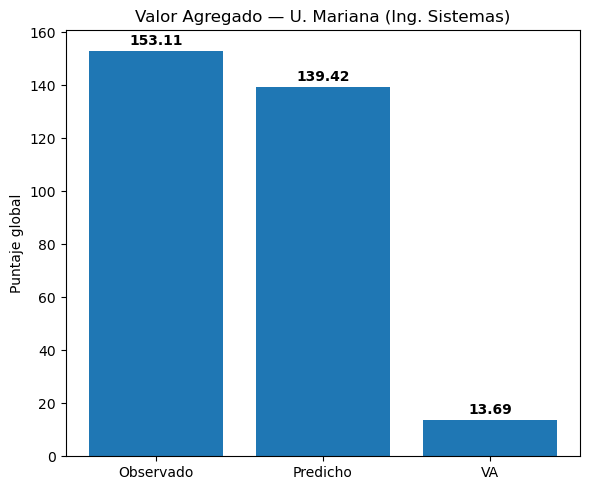

In [10]:
# --- 1) RANKING (ya lo tenías) ---
df_rank = df_prog.dropna(subset=base_cols + ['punt_global_prom']).copy()
df_rank['_pred'] = pipe.predict(df_rank[X_num + X_cat].copy())
df_rank['VA'] = df_rank['punt_global_prom'] - df_rank['_pred']
df_rank = df_rank[[col_inst, col_prog, 'key_muni', 'punt_global_prom', '_pred', 'VA']] \
             .sort_values('VA', ascending=False)

df_rank.to_csv(OUT_DIR / 'ranking_va_programas_narino.csv', index=False, encoding='utf-8-sig')
print("✅ Guardado ranking:", OUT_DIR / 'ranking_va_programas_narino.csv')
print(df_rank.head(10).to_string(index=False))

# --- Localiza explícitamente el programa objetivo (asegura índices) ---
mask_um_sis = (df_rank[col_inst].astype(str).str.upper().str.contains('MARIANA')) & \
              (df_rank[col_prog].astype(str).str.upper().str.contains('SISTEM'))
assert mask_um_sis.any(), "No encontré el programa UM - Ing. Sistemas en df_rank"
row_obj = df_rank.loc[mask_um_sis].iloc[0]
y_obs = float(row_obj['punt_global_prom'])
y_hat = float(row_obj['_pred'])
va    = float(row_obj['VA'])

# --- 2) BARRAS: Observado vs Predicho vs VA (resalta claramente la diferencia) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
vals = [y_obs, y_hat, va]
labels = ['Observado', 'Predicho', 'VA']
bars = plt.bar(labels, vals)
# Etiquetas numéricas arriba
for b, v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width()/2, v + 1, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
plt.ylabel("Puntaje global")
plt.title("Valor Agregado — U. Mariana (Ing. Sistemas)")
plt.tight_layout()
plt.show()






## 4. Visualización del Valor Agregado (VA) — Cohorte 2019–2023

La gráfica muestra la comparación entre el puntaje **observado** en Saber Pro y el puntaje **predicho** por el modelo (baseline de Saber 11), así como el **Valor Agregado (VA)** estimado:

- **Observado (≈ 153.11):** desempeño real de los estudiantes en el examen Saber Pro.  
- **Predicho (≈ 139.42):** lo que se esperaba según el baseline municipal de Saber 11.  
- **Diferencia (≈ +13.69):** corresponde al **Valor Agregado (VA)** del programa.

---

### Interpretación

El programa de **Ingeniería de Sistemas — Universidad Mariana** exhibe un **VA positivo de +13.7 puntos** en la cohorte 2019–2023.  
Esto indica que los estudiantes alcanzan un puntaje **muy superior al esperado** en Saber Pro, después de controlar por el desempeño previo en Saber 11.  

El hallazgo refuerza la evidencia de un **impacto institucional consistente** en la formación, consolidando una trayectoria de resultados positivos en los análisis longitudinales.


---------------------------------------------------------------------------------------------------


*OBJETIVO 3* 


**2.Codigo par exportar para AI web**


En este codigo estamos exportando todos los datso nececessario para poder relaizar la AI para el tercer objetivo.📦 Exportador de EDA + Dataset (listo para BD)

Este notebook no recalcula tus EDA; usa los DataFrames que ya generaste (s11, sp, s11_base, prog_tbl, X, train, df_rank) y exporta los artefactos listos para cargarlos en la base de datos .
| Archivo                                | Contenido principal                                               | Uso                                   |
| -------------------------------------- | ----------------------------------------------------------------- | ------------------------------------- |
| **s11\_YYYY\_muni\_summary\_YYYY.csv** | Promedios Saber 11 por municipio (LC, MAT, SOC, NAT, ING)         | Contexto y baseline para modelos/VA   |
| **eda\_colegio\_YYYY.csv**             | Resultados por colegio: n\_estu, medias por área, p25/p50/p75, sd | Contexto institucional en la interfaz |
| **eda\_programa\_YYYY.csv**            | Resultados por programa: n, media global, percentiles, sd         | Rankings y tableros comparativos      |
| **train\_features\_YYYY.csv**          | Variables predictoras (S11 + categóricas)                         | Entrenamiento de modelos              |
| **train\_labels\_YYYY.csv**            | Puntaje global promedio (label)                                   | Entrenamiento de modelos              |
| **va\_programa\_YYYY.csv**             | VA agregado por programa: n, media, sd, IC95%, obs/pred           | Comparaciones y ranking de programas  |
| **ranking\_va\_programas\_YYYY.csv**   | Ranking ordenado por VA                                           | Visualización en la interfaz          |
| **manifest.json**                      | Año, carpeta de salida, archivos exportados, shapes               | Registro y trazabilidad               |




In [16]:
# =============================================================================
# EXPORTADOR EDA + DATASET (una sola línea para cambiar el año)
# Cambia ÚNICAMENTE esta línea:
YEAR = 2023
# =============================================================================

from pathlib import Path
import pandas as pd, numpy as np, json, warnings

# ---------- Paths / encoding ----------
OUT_DIR = Path(rf"C:\Temp\eda_exports_{YEAR}")
OUT_DIR.mkdir(parents=True, exist_ok=True)
ENC = "utf-8-sig"

# ---------- Helpers ----------
def exists_df(name):
    return name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty

def get_df(name, default=None):
    return globals()[name].copy() if exists_df(name) else (default.copy() if isinstance(default, pd.DataFrame) else pd.DataFrame())

def add_year(df):
    df = df.copy()
    if not df.empty and "anio" not in df.columns:
        df["anio"] = YEAR
    return df

def pct(s, q):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return float(np.nanpercentile(s, q)) if len(s) else np.nan

def save_csv(df, basename):
    if df is None or df.empty:
        return None
    df = add_year(df)
    f = OUT_DIR / f"{basename}_{YEAR}.csv"
    df.to_csv(str(f), index=False, encoding=ENC)
    print("✅ Guardado:", f)
    return f.name

# ---------- Detectar DFs del entorno ----------
s11       = get_df("s11")
sp        = get_df("sp")
s11_base  = get_df("s11_base")
prog_tbl  = get_df("prog_tbl")
X_df      = get_df("X")
train_df  = get_df("train")
df_rank   = get_df("df_rank")   # opcional (para VA agregado)

print(f"[INFO] s11: {s11.shape}, sp: {sp.shape}, s11_base: {s11_base.shape}, prog_tbl: {prog_tbl.shape}, X: {X_df.shape}, train: {train_df.shape}, df_rank: {df_rank.shape}")

# =============================================================================
# 1) Baseline municipal S11  -> s11_{YEAR}_muni_summary_{YEAR}.csv
# =============================================================================
baseline_out = None
if not s11_base.empty:
    num_like = [c for c in ["prom_lc","prom_mat","prom_soc","prom_nat","prom_ing",
                            "punt_lc","punt_mat","punt_soc","punt_nat","punt_ing","punt_global"] if c in s11_base.columns]
    if num_like:
        s11_base[num_like] = s11_base[num_like].apply(pd.to_numeric, errors="coerce")
    baseline_out = save_csv(s11_base, f"s11_{YEAR}_muni_summary")
elif not s11.empty:
    muni_cols = [c for c in ["municipio_id","cole_mcpio_ubicacion","estu_mcpio_presentacion","key_muni"] if c in s11.columns]
    if muni_cols:
        mc = muni_cols[0]
        area_alias = {
            "punt_lectura_critica": "lc", "punt_lenguaje": "lc", "punt_lc": "lc",
            "punt_matematicas": "mat", "punt_mat": "mat",
            "punt_sociales_ciudadanas": "soc", "punt_soc": "soc",
            "punt_c_naturales": "nat", "punt_nat": "nat",
            "punt_ingles": "ing", "punt_ing": "ing",
        }
        cols_present = [c for c in area_alias.keys() if c in s11.columns]
        if cols_present:
            tmp = s11[[mc] + cols_present].copy()
            gb = tmp.groupby(mc).agg({c: "mean" for c in cols_present}).reset_index()
            baseline = gb.rename(columns={c: f"prom_{area_alias[c]}" for c in cols_present})
            if mc != "municipio_id":
                baseline = baseline.rename(columns={mc: "municipio_id"})
            baseline_out = save_csv(baseline, f"s11_{YEAR}_muni_summary")
        else:
            print("⚠️ No hay columnas de puntaje S11 para baseline.")
    else:
        print("⚠️ No hay columna de municipio en s11 para baseline.")
else:
    print("ℹ️ Sin s11/s11_base: se omite baseline.")

# =============================================================================
# 2) EDA por COLEGIO  -> eda_colegio_{YEAR}.csv
# =============================================================================
eda_colegio_out = None
if not s11.empty:
    colegio_name_col = "cole_nombre_establecimiento"
    muni_candidates = ["municipio_id","cole_mcpio_ubicacion","estu_mcpio_presentacion","key_muni"]
    muni_col = next((c for c in muni_candidates if c in s11.columns), None)

    if colegio_name_col in s11.columns:
        df_c = s11.copy()
        df_c["__colegio_key__"] = df_c[colegio_name_col].astype(str).str.strip()
        if muni_col:
            df_c["__colegio_key__"] = df_c["__colegio_key__"] + " | " + df_c[muni_col].astype(str).str.strip()

        def _col(*opts): 
            return next((c for c in opts if c in df_c.columns), None)

        col_lc  = _col("punt_lectura_critica","punt_lc","punt_lenguaje")
        col_mat = _col("punt_matematicas","punt_mat")
        col_soc = _col("punt_sociales_ciudadanas","punt_soc")
        col_nat = _col("punt_c_naturales","punt_nat")
        col_ing = _col("punt_ingles","punt_ing")
        col_glo = _col("punt_global")

        agg = {"n_estu": ("__colegio_key__", "size")}
        if col_lc:  agg["media_lc"]  = (col_lc, "mean")
        if col_mat: agg["media_mat"] = (col_mat, "mean")
        if col_soc: agg["media_soc"] = (col_soc, "mean")
        if col_nat: agg["media_nat"] = (col_nat, "mean")
        if col_ing: agg["media_ing"] = (col_ing, "mean")
        if col_glo:
            agg["media_global"] = (col_glo,"mean")
            agg["p25_global"]   = (col_glo, lambda s: pct(s,25))
            agg["p50_global"]   = (col_glo,"median")
            agg["p75_global"]   = (col_glo, lambda s: pct(s,75))
            agg["sd_global"]    = (col_glo,"std")

        eda_c = df_c.groupby("__colegio_key__", dropna=False).agg(**agg).reset_index()

        if muni_col:
            split = eda_c["__colegio_key__"].str.split(" \| ", n=1, expand=True)
            eda_c["colegio_nombre"] = split[0]
            eda_c[muni_col] = split[1]
        else:
            eda_c["colegio_nombre"] = eda_c["__colegio_key__"]

        eda_c = eda_c.drop(columns=["__colegio_key__"])
        eda_colegio_out = save_csv(eda_c, "eda_colegio")
    else:
        print("ℹ️ s11 no tiene 'cole_nombre_establecimiento'; se omite eda_colegio.")
else:
    print("ℹ️ s11 vacío; se omite eda_colegio.")

# =============================================================================
# 3) EDA por PROGRAMA  -> eda_programa_{YEAR}.csv
# =============================================================================
eda_programa_out = None
if not prog_tbl.empty:
    ren_map = {}
    if "punt_global_prom" in prog_tbl.columns and "media_global" not in prog_tbl.columns:
        ren_map["punt_global_prom"] = "media_global"
    eda_programa_out = save_csv(prog_tbl.rename(columns=ren_map), "eda_programa")
elif not sp.empty:
    prog_keys = [c for c in ["programa_id","prog_cod_snies","programa","programa_nombre"] if c in sp.columns]
    if prog_keys:
        pk = prog_keys[0]
        g = sp.groupby(pk, dropna=True)
        eda_p2 = g.agg(
            n=(pk,"size"),
            media_global=("punt_global","mean") if "punt_global" in sp.columns else (pk,"size"),
            p25=("punt_global", lambda s: pct(s,25)) if "punt_global" in sp.columns else (pk,"size"),
            p50=("punt_global","median") if "punt_global" in sp.columns else (pk,"size"),
            p75=("punt_global", lambda s: pct(s,75)) if "punt_global" in sp.columns else (pk,"size"),
            sd=("punt_global","std") if "punt_global" in sp.columns else (pk,"size"),
        ).reset_index()
        if pk != "programa_id":
            eda_p2 = eda_p2.rename(columns={pk: "programa_id"})
        eda_programa_out = save_csv(eda_p2, "eda_programa")
    else:
        print("ℹ️ No hay llave de programa en sp; se omite eda_programa.")
else:
    print("ℹ️ prog_tbl y sp vacíos; se omite eda_programa.")

# =============================================================================
# 4) TRAIN features & labels  -> train_features_{YEAR}.csv / train_labels_{YEAR}.csv
# =============================================================================
train_features_out = None
train_labels_out   = None

# Features
if not X_df.empty:
    feats = X_df.copy()
elif not train_df.empty:
    base_cols = globals().get("base_cols", [])
    X_cat = [c for c in ["inst_origen", "inst_caracter_academico"] if c in train_df.columns]
    cols  = [c for c in (list(base_cols) + X_cat) if c in train_df.columns]
    if not cols:
        cols = [c for c in train_df.columns if c not in ["punt_global_prom","spro_global","punt_global","y","target","label"]]
    feats = train_df[cols].copy()
else:
    feats = pd.DataFrame()

if not feats.empty:
    train_features_out = save_csv(feats, "train_features")

# Labels
y_arr = globals().get("y", None)
labels_df = None
if y_arr is not None and isinstance(y_arr, (np.ndarray, list)) and len(y_arr) > 0:
    labels_df = pd.DataFrame({"spro_global": pd.to_numeric(np.asarray(y_arr), errors="coerce")})
elif not train_df.empty:
    label_candidates = ["punt_global_prom","spro_global","punt_global","y","target","label"]
    lc = next((c for c in label_candidates if c in train_df.columns), None)
    if lc:
        labels_df = pd.DataFrame({"spro_global": pd.to_numeric(train_df[lc], errors="coerce")})

if labels_df is not None:
    train_labels_out = save_csv(labels_df, "train_labels")
else:
    print("ℹ️ No se encontraron labels en train/y; se omite train_labels.")

# =============================================================================
# 5) VA por PROGRAMA (agregado)  -> va_programa_{YEAR}.csv  (+ ranking opcional)
# =============================================================================
va_programa_out = None
rank_agregado_out = None

if not df_rank.empty:
    col_inst = globals().get("col_inst", "inst_nombre_institucion")
    col_prog = globals().get("col_prog", "estu_prgm_academico")
    muni_col = "key_muni"

    required = [col_inst, col_prog, muni_col, "VA", "punt_global_prom", "_pred"]
    missing = [c for c in required if c not in df_rank.columns]
    if missing:
        print(f"⚠️ df_rank sin columnas {missing}; no se exporta va_programa.")
    else:
        df_r = df_rank.copy()
        df_r["programa_id"] = (
            df_r[col_inst].astype(str).str.strip().str.upper() + " | " +
            df_r[col_prog].astype(str).str.strip().str.upper() + " | " +
            df_r[muni_col].astype(str).str.strip().str.upper()
        )
        grp = df_r.groupby("programa_id", dropna=False)
        agg = grp.agg(
            n=("VA", "size"),
            va_promedio=("VA", "mean"),
            sd=("VA", "std"),
            media_obs=("punt_global_prom", "mean"),
            media_pred=("_pred", "mean"),
        ).reset_index()
        agg["sd"] = agg["sd"].fillna(0.0)
        agg["se"] = agg["sd"] / np.sqrt(agg["n"].clip(lower=1))
        agg["ic95_inf"] = agg["va_promedio"] - 1.96 * agg["se"]
        agg["ic95_sup"] = agg["va_promedio"] + 1.96 * agg["se"]
        split = agg["programa_id"].str.split(" \| ", expand=True)
        agg["inst_nombre_institucion"] = split[0]
        agg["estu_prgm_academico"]    = split[1]
        agg["key_muni"]               = split[2]
        agg = agg.sort_values("va_promedio", ascending=False).reset_index(drop=True)
        agg["anio"] = YEAR

        cols_out = [
            "anio","programa_id","n","va_promedio","sd","ic95_inf","ic95_sup",
            "inst_nombre_institucion","estu_prgm_academico","key_muni","media_obs","media_pred"
        ]
        va_programa_out = save_csv(agg[cols_out], "va_programa")

        # Ranking agregado (opcional)
        topK = 50
        rank_agregado_out = save_csv(agg[cols_out].head(topK), "ranking_va_programas")
else:
    print("ℹ️ df_rank vacío/inexistente; si quieres va_programa, genera df_rank antes.")

# =============================================================================
# 6) MANIFEST
# =============================================================================
exports = [name for name in [
    baseline_out, eda_colegio_out, eda_programa_out,
    train_features_out, train_labels_out,
    va_programa_out, rank_agregado_out
] if name]

manifest = {
    "year": YEAR,
    "out_dir": str(OUT_DIR),
    "exports": exports,
    "diagnostics": {
        "s11": s11.shape, "sp": sp.shape, "s11_base": s11_base.shape,
        "prog_tbl": prog_tbl.shape, "X": X_df.shape,
        "train": train_df.shape, "df_rank": df_rank.shape
    }
}
(OUT_DIR / "manifest.json").write_text(json.dumps(manifest, ensure_ascii=False, indent=2), encoding=ENC)
print("📦 Manifest:", manifest)


[INFO] s11: (18121, 20), sp: (4513, 26), s11_base: (18120, 7), prog_tbl: (80, 7), X: (364412, 8), train: (364412, 13), df_rank: (364412, 7)
✅ Guardado: C:\Temp\eda_exports_2023\s11_2023_muni_summary_2023.csv
✅ Guardado: C:\Temp\eda_exports_2023\eda_colegio_2023.csv
✅ Guardado: C:\Temp\eda_exports_2023\eda_programa_2023.csv
✅ Guardado: C:\Temp\eda_exports_2023\train_features_2023.csv
✅ Guardado: C:\Temp\eda_exports_2023\train_labels_2023.csv
✅ Guardado: C:\Temp\eda_exports_2023\va_programa_2023.csv
✅ Guardado: C:\Temp\eda_exports_2023\ranking_va_programas_2023.csv
📦 Manifest: {'year': 2023, 'out_dir': 'C:\\Temp\\eda_exports_2023', 'exports': ['s11_2023_muni_summary_2023.csv', 'eda_colegio_2023.csv', 'eda_programa_2023.csv', 'train_features_2023.csv', 'train_labels_2023.csv', 'va_programa_2023.csv', 'ranking_va_programas_2023.csv'], 'diagnostics': {'s11': (18121, 20), 'sp': (4513, 26), 's11_base': (18120, 7), 'prog_tbl': (80, 7), 'X': (364412, 8), 'train': (364412, 13), 'df_rank': (36441

In [17]:
# ============================================================
# EDA por colegio — Robusto a nombres de columnas (patrones)
# ============================================================
from pathlib import Path
import pandas as pd, numpy as np
import re

# ---- helpers ----
def pct(s, q):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return float(np.nanpercentile(s, q)) if len(s) else np.nan

def save_csv(df, basename, out_dir, anio, enc="utf-8-sig"):
    out_dir.mkdir(parents=True, exist_ok=True)
    f = out_dir / f"{basename}_{anio}.csv"
    df.to_csv(str(f), index=False, encoding=enc)
    print("✅ Guardado:", f)
    return str(f)

def find_col(cols, patterns):
    """
    Busca la PRIMERA columna cuyo nombre case-insensitive haga match con
    cualquiera de los patrones (regex simples o substrings).
    """
    low = {c.lower(): c for c in cols}
    for pat in patterns:
        rx = re.compile(pat, flags=re.I)
        for lc, orig in low.items():
            if rx.search(lc):
                return orig
    return None

# ---- configuración de salida ----
YEAR = int(globals().get("YEAR", 2024))
OUT_DIR = Path(rf"C:\Temp\eda_exports_{YEAR}")

# ---- validación de s11 ----
if "s11" not in globals() or not isinstance(s11, pd.DataFrame) or s11.empty:
    raise RuntimeError("No encuentro DataFrame 's11' o está vacío.")

cols = list(s11.columns)
print("[INFO] columnas s11 (muestra):", cols[:20])

# ---- detectar llaves: colegio / municipio / periodo|anio ----
colegio_col   = find_col(cols, [r"^cole_?nombre_?establecimiento$", r"colegio.*nombre", r"establecimiento"])
municipio_col = find_col(cols, [r"^cole_?mcpio_?ubicacion$", r"mcpio", r"municipio"])
anio_col      = find_col(cols, [r"^periodo$", r"^anio$", r"^año$", r"^year$"])

if not colegio_col:
    raise RuntimeError("No encontré columna de colegio (p.ej. 'cole_nombre_establecimiento').")
if not municipio_col:
    print("⚠️ No encontré municipio; continuaré sin municipio.")
if not anio_col:
    raise RuntimeError("No encontré columna de año/periodo (p.ej. 'periodo' o 'anio').")

# ---- detectar puntajes por patrones ----
map_targets = {
    "punt_global":               [r"^punt_?global$","global\s*$","puntaje_?global$"],
    "punt_matematicas":          [r"^punt_?mat(ematicas)?$", r"matematicas$"],
    "punt_lectura_critica":      [r"^punt_?(lectura_?critica|lc|lenguaje)$", r"lectura", r"lenguaje"],
    "punt_sociales_ciudadanas":  [r"^punt_?(social(es)?_?ciudadanas?)$", r"sociales"],
    "punt_c_naturales":          [r"^punt_?(c_?naturales|naturales)$", r"naturales$"],
    "punt_ingles":               [r"^punt_?ingles$", r"ingles$"],
}

found = {}
for k, pats in map_targets.items():
    col = find_col(cols, pats)
    if col: found[k] = col

print("[INFO] mapeo de puntajes detectado:", found)

if not found:
    raise RuntimeError("No encontré NINGUNA columna de puntajes en s11 (revisa nombres).")

# ---- construir DF base ----
df = s11.copy()

# año
df["anio"] = pd.to_numeric(df[anio_col], errors="coerce").astype("Int64")
df = df.dropna(subset=["anio"]).copy()
df["anio"] = df["anio"].astype(int)

# normaliza llaves texto
df[colegio_col] = df[colegio_col].astype(str).str.strip()
if municipio_col:
    df[municipio_col] = df[municipio_col].astype(str).str.strip()

# fuerza numérico en las columnas de puntajes encontradas
for k, col in found.items():
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- agrupación (anio, colegio [, municipio]) ----
group_keys = ["anio", colegio_col] + ([municipio_col] if municipio_col else [])
gb = df.groupby(group_keys, dropna=False)

# arma agregaciones dinámicamente
agg = {"n_estu": (next(iter(found.values())), "size")}  # usa cualquier puntaje para contar filas
# medias por competencia
if "punt_lectura_critica" in found:     agg["media_lc"]  = (found["punt_lectura_critica"], "mean")
if "punt_matematicas" in found:         agg["media_mat"] = (found["punt_matematicas"], "mean")
if "punt_sociales_ciudadanas" in found: agg["media_soc"] = (found["punt_sociales_ciudadanas"], "mean" )
if "punt_c_naturales" in found:         agg["media_nat"] = (found["punt_c_naturales"], "mean")
if "punt_ingles" in found:              agg["media_ing"] = (found["punt_ingles"], "mean")

# estadísticas de global si existe
if "punt_global" in found:
    c = found["punt_global"]
    agg["media_global"] = (c, "mean")
    agg["p25_global"]   = (c, lambda s: pct(s,25))
    agg["p50_global"]   = (c, "median")
    agg["p75_global"]   = (c, lambda s: pct(s,75))
    agg["sd_global"]    = (c, "std")

eda_c = gb.agg(**agg).reset_index()

# renombres de salida
eda_c = eda_c.rename(columns={
    colegio_col: "colegio_nombre",
    (municipio_col or "cole_mcpio_ubicacion"): "cole_mcpio_ubicacion"  # si no hay, crea col luego
})

if municipio_col is None and "cole_mcpio_ubicacion" not in eda_c.columns:
    eda_c["cole_mcpio_ubicacion"] = pd.NA

# orden columnas
out_cols = ["anio","colegio_nombre","cole_mcpio_ubicacion","n_estu",
            "media_global","media_lc","media_mat","media_soc","media_nat","media_ing",
            "p25_global","p50_global","p75_global","sd_global"]
existing = [c for c in out_cols if c in eda_c.columns]
eda_c = eda_c[existing]

print(f"[INFO] filas generadas: {len(eda_c)} | años: {sorted(eda_c['anio'].unique())[:10]} …")
print(eda_c.head(5))

# guardar un archivo por año (como vienes trabajando)
for anio_i, sub in eda_c.groupby("anio"):
    save_csv(sub, "eda_colegio", OUT_DIR, anio_i)

[INFO] columnas s11 (muestra): ['cole_cod_depto_ubicacion', 'cole_cod_mcpio_ubicacion', 'cole_depto_ubicacion', 'cole_mcpio_ubicacion', 'cole_nombre_establecimiento', 'cole_naturaleza', 'cole_area_ubicacion', 'cole_jornada', 'cole_genero', 'estu_genero', 'estu_inse_individual', 'fami_estratovivienda', 's11_punt_global', 's11_punt_matematicas', 's11_punt_lectura_critica', 's11_punt_sociales_ciudadanas', 's11_punt_c_naturales', 's11_punt_ingles', 'periodo', 'key_muni']
[INFO] mapeo de puntajes detectado: {'punt_global': 's11_punt_global', 'punt_matematicas': 's11_punt_matematicas', 'punt_lectura_critica': 's11_punt_lectura_critica', 'punt_sociales_ciudadanas': 's11_punt_sociales_ciudadanas', 'punt_c_naturales': 's11_punt_c_naturales', 'punt_ingles': 's11_punt_ingles'}
[INFO] filas generadas: 415 | años: [20191, 20192] …
    anio                        colegio_nombre cole_mcpio_ubicacion  n_estu  \
0  20191          CENTRO EDUCATIVO BOLIVARIANO                PASTO      46   
1  20191    